In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt


import glob, os
import torch
import numpy as np

import config_matplotlib
config_matplotlib.config_matplotlib()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

registered cmap: seaborn_cubehelix



/global/u2/z/zhantao/Projects/inxs_steering/paper_preperation/config_matplotlib.py:44: UserWarning: Trying to register the cmap 'seaborn_cubehelix' which already exists.
  plt.register_cmap(cmap=cmap)


In [12]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'

In [13]:
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [14]:
steps_of_interest = [25, 50]

In [15]:
mean_preds = []
true_values = []
sample_ids = []
maes = []

for path in summary_dict['simulation']['poisson_scaled']:
    pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
    pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

    for _idx, _idx in enumerate(pt_indices):
        _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx}.pt'))
        # print(_pt.keys())
        _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
        _maes = (_mean_preds - _pt['true_params'][None]).norm(dim=-1)
        
        mean_preds.append(_mean_preds.unsqueeze(0))
        maes.append(_maes[steps_of_interest].unsqueeze(0))
        sample_ids.append(_idx)
        true_values.append(_pt['true_params'])

maes = torch.vstack(maes).numpy()
mean_preds = torch.vstack(mean_preds).numpy()
sample_ids = torch.tensor(sample_ids).numpy()
true_values = torch.vstack(true_values).numpy()

[Text(0, 0.0, '0'),
 Text(0, 3.0, '3'),
 Text(0, 6.0, '6'),
 Text(0, 9.0, '9'),
 Text(0, 12.0, '12'),
 Text(0, 15.0, '15'),
 Text(0, 18.0, '18')]

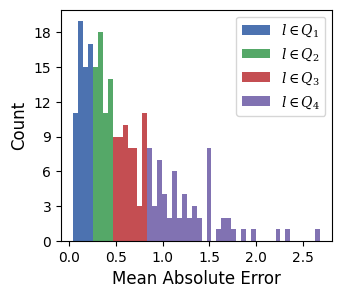

In [16]:
mae_sorted_quartiles_idx = np.split(np.argsort(maes[:,-1]), 4)
mae_sorted_quartiles = np.split(np.sort(maes[:,-1]), 4)

# fig, ax = plt.subplots(1,1)
# ax.hist(maes[:,-1], bins=60)
# mae_sorted_quartiles = np.split(np.sort(maes[:,-1]), 4)

fig, ax = plt.subplots(1,1,figsize=(3.5, 3))
n, bins, patches = ax.hist(maes[:,-1], bins=50)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

start_ids = []
for i in range(4):
    start = np.where(bin_centers > mae_sorted_quartiles[i].min())[0][0]
    start_ids.append(start)
    for patch in patches[start:]:
        patch.set_facecolor(f'C{i}')
        
# Add legend for each color
legend_labels = [fr'$l\in Q_{_j+1}$' for _j in range(4)]
legend_patches = [patches[start] for start in start_ids]
ax.legend(legend_patches, legend_labels)

ax.set_xlabel('Mean Absolute Error')
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0, np.ceil(n.max())+1, step=3))
ax.set_yticklabels(np.arange(0, np.ceil(n.max())+1, step=3).astype('int'))

# fig.savefig('figures/siml_benchmark_hist.pdf', bbox_inches='tight')

In [38]:
mae_sorted_quartiles_idx = np.split(np.argsort(maes[-60:,-1]), 4)
mae_sorted_quartiles = np.split(np.sort(maes[-60:,-1]), 4)

# pick the lower right corner within q4
# relative_idx_of_interest = mae_sorted_quartiles_idx[-1][true_values[-60:,1][mae_sorted_quartiles_idx[-1]].argmin()]
relative_idx_of_interest = 12

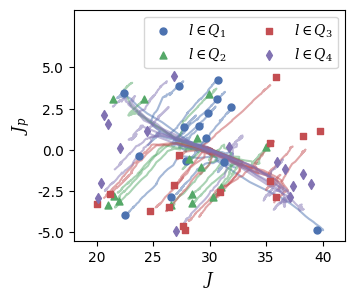

In [39]:
N_samp = mean_preds.shape[1]

N_samp_interp = 100

step = 20

markers = ['o', '^', 's', 'd']
fig, ax = plt.subplots(1,1,figsize=(3.5, 3))
for _j in range(4):
    
    np.random.seed(9)
    rdn_idx = np.random.choice(mae_sorted_quartiles_idx[_j], len(mae_sorted_quartiles_idx[_j]), replace=False)
    for _idx in rdn_idx:
        
        ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C{_j}', alpha=0.5, zorder=1)
        
        ax.scatter(true_values[_idx,0], true_values[_idx,1], 
                   color=f'C{_j}', marker=markers[_j], zorder=10, s=25,
                   label=fr'$l\in Q_{_j+1}$' if _idx==rdn_idx[0] else None)
        
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
ax.set_xlim(18, 42)
ax.set_xticks(np.linspace(20, 40, 5, dtype=int))
ax.set_xticklabels(np.linspace(20, 40, 5, dtype=int))
ax.set_ylim(-5.5, 8.5)
ax.set_yticks(np.linspace(-5, 5, 5))
ax.set_yticklabels(np.linspace(-5, 5, 5))
ax.legend(loc='upper right', ncol=2)

# fig.savefig('figures/siml_benchmark_trajs.pdf', bbox_inches='tight')


In [40]:

unique_ids = list(set(sorted(sample_ids.tolist())))
demo_ids = unique_ids[0]

In [41]:
from sklearn.neighbors import KernelDensity
import numpy as np
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(_pt['positions'][-1], sample_weight=_pt['weights'][-1])
J, Jp = np.meshgrid(np.linspace(20, 40, 401), np.linspace(-5, 5, 201))
param_grid = np.concatenate([J[..., None], Jp[..., None]], axis=-1)
log_density = kde.score_samples(param_grid.reshape(-1, 2)).reshape(J.shape)

/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


In [42]:
def kde_particle_to_grid(positions, weights, kde_kwargs=None):
    if kde_kwargs is None:
        kde_kwargs = {'kernel': 'gaussian', 'bandwidth': 0.5}
    kde = KernelDensity(**kde_kwargs).fit(positions, sample_weight=weights)
    J, Jp = np.meshgrid(np.linspace(20, 40, 401), np.linspace(-5, 5, 201))
    param_grid = np.concatenate([J[..., None], Jp[..., None]], axis=-1)
    log_density = kde.score_samples(param_grid.reshape(-1, 2)).reshape(J.shape)
    density = np.exp(log_density)
    return density, J, Jp

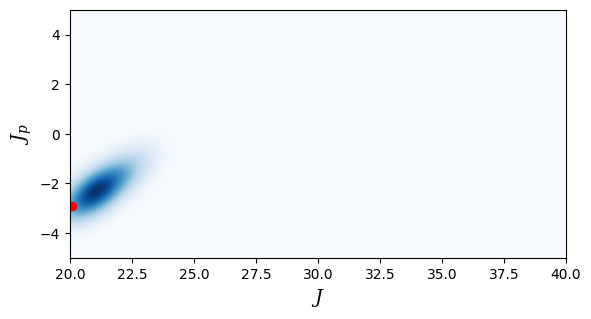

In [43]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_density), origin='lower', extent=[20, 40, -5, 5], 
          aspect='equal', cmap='Blues')
ax.scatter(_pt['true_params'][0], _pt['true_params'][1], color='red')
ax.set_xlabel('$J$', fontdict={'size': 14})
ax.set_ylabel('$J_{p}$', fontdict={'size': 14});

In [44]:
demo_idx = sample_ids[relative_idx_of_interest]

demo_pt = torch.load(os.path.join(
    summary_dict['path'], 
    summary_dict['simulation']['gaussian_0.1_scaled'][-1], 
    f'{demo_idx}.pt'))

In [45]:
demo_pt.keys()

dict_keys(['means', 'positions', 'weights', 'measured_angles', 'background_signal_factors', 'utility', 'likelihood', 'true_params'])

Text(0, 0.5, 'Measured Angle (deg)')

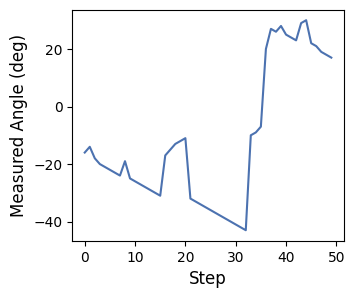

In [46]:
_measured_angles = demo_pt['measured_angles']
_measured_angles[_measured_angles > 180] -= 360

# idx_of_interest = 27

fig, ax = plt.subplots(1,1, figsize=(3.5, 3))
ax.plot(_measured_angles)
ax.set_xlabel('Step')
ax.set_ylabel('Measured Angle (deg)')
# plt.plot(np.abs(_measured_angles))
# plt.scatter(idx_of_interest, _measured_angles[idx_of_interest])

# fig.savefig('figures/siml_benchmark_measured_angles.pdf', bbox_inches='tight')

In [47]:
import sys
sys.path.append('..')

from inxss.utils_visualization import visualize_utility


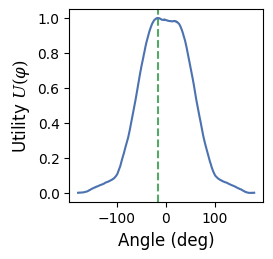

In [58]:
# fig = plt.figure(figsize=(2.5, 2.5))
# ax = fig.add_subplot(111, projection='polar')
# visualize_utility(np.arange(360), demo_pt['utility'][0], ax=ax)
# fig.savefig('figures/siml_benchmark_util_inset.pdf', bbox_inches='tight')

util = demo_pt['utility'][0]
util = (util - util.min()) / (util.max() - util.min())

angles = np.arange(360)
angles[angles>180] -= 360

util = np.concatenate([util[angles<0], util[angles>=0]], axis=0)
angles = np.concatenate([angles[angles<0], angles[angles>=0]], axis=0)

# angles = np.roll(angles, -1)
# util = np.roll(util, -1)

fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
ax.plot(angles, util)
ax.vlines(angles[util.argmax()], -1, 2, color='C1', linestyle='--')
ax.set_xlabel('Angle (deg)')
ax.set_ylabel(r'Utility $U(\varphi)$')
ax.set_ylim([-0.05, 1.05])
fig.savefig('figures/siml_benchmark_util_inset.pdf', bbox_inches='tight')

In [67]:
idx_prior = 2
kde_prior, _, _ = kde_particle_to_grid(demo_pt['positions'][idx_prior], demo_pt['weights'][idx_prior])
kde_poste, _, _ = kde_particle_to_grid(demo_pt['positions'][idx_prior+1], demo_pt['weights'][idx_prior+1])
kde_lkhd, _, _ = kde_particle_to_grid(demo_pt['positions'][idx_prior], demo_pt['likelihood'][idx_prior])

/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


In [68]:
demo_pt['true_params']

tensor([21.0442, -3.3076], dtype=torch.float64)

In [69]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

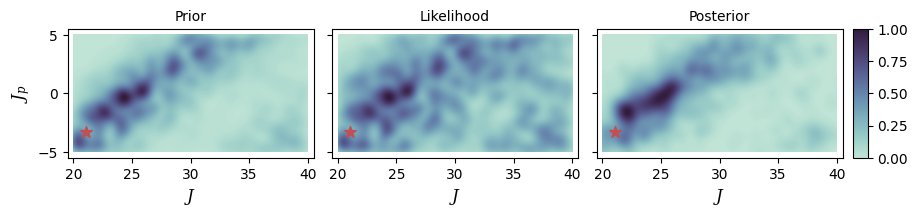

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharey=True, gridspec_kw={'wspace': 0.075})

cmap = plt.get_cmap('seaborn_cubehelix')

kde_prior = (kde_prior - kde_prior.min()) / (kde_prior.max() - kde_prior.min())
kde_lkhd = (kde_lkhd - kde_lkhd.min()) / (kde_lkhd.max() - kde_lkhd.min())
kde_poste = (kde_poste - kde_poste.min()) / (kde_poste.max() - kde_poste.min())

im0 = ax[0].imshow(kde_prior, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax[0].set_title('Prior')
ax[0].set_xlabel('$J$')
ax[0].set_ylabel('$J_{p}$')
ax[0].scatter(*demo_pt['true_params'], s=75, marker='*', color='C2')
ax[0].set_xlim(19.5, 40.5)
ax[0].set_ylim(-5.5, 5.5)

im1 = ax[1].imshow(kde_lkhd, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax[1].scatter(*demo_pt['true_params'], s=75, marker='*', color='C2')
ax[1].set_title('Likelihood')
ax[1].set_xlabel('$J$')
ax[1].set_xlim(19.5, 40.5)
ax[1].set_ylim(-5.5, 5.5)

im2 = ax[2].imshow(kde_poste, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax[2].scatter(*demo_pt['true_params'], s=75, marker='*', color='C2')
ax[2].set_title('Posterior')
ax[2].set_xlabel('$J$')
ax[2].set_xlim(19.5, 40.5)
ax[2].set_ylim(-5.5, 5.5)

fraction_positions = ax[2].get_position()

# Add colorbar
cbar_ax = fig.add_axes([
    fraction_positions.p1[0]+0.01, fraction_positions.p0[1], 
    0.015, fraction_positions.height])

fig.colorbar(im2, cax=cbar_ax)


fig.savefig('figures/siml_benchmark_bayesian_demo.pdf', bbox_inches='tight')

In [71]:
demo_pt_mean = (demo_pt['positions'] * demo_pt['weights'].unsqueeze(-1)).sum(dim=-2) / demo_pt['weights'].sum(dim=-1).unsqueeze(-1)

In [72]:
weights_sq_sum = torch.sum(demo_pt['weights']**2, dim=1)
normalization_factor = 1 / (1 - weights_sq_sum + torch.finfo(demo_pt['weights'].dtype).eps)
var = normalization_factor.unsqueeze(-1) * torch.sum(demo_pt['weights'].unsqueeze(-1) * (demo_pt['positions'] - demo_pt['means'].unsqueeze(1))**2, dim=1)
std = var.sqrt()

Text(0, 0.5, 'Parameter Value')

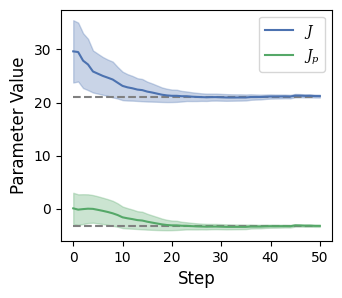

In [73]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 3))
ax.plot(np.arange(demo_pt['means'].shape[0]), demo_pt['means'])
ax.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,0], 
                (demo_pt['means'] + std)[:,0], alpha=0.3, color='C0')
ax.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,1], 
                (demo_pt['means'] + std)[:,1], alpha=0.3, color='C1')
ax.hlines(demo_pt['true_params'], 0, 49, color='gray', linestyle='--')
# ax.plot([idx_prior, idx_prior+1], [demo_pt_mean[i] for i in [idx_prior,idx_prior+1]], 'o', color='C2')

ax.legend(['$J$', '$J_{p}$'])
ax.set_xlabel('Step')
ax.set_ylabel('Parameter Value')
# fig.savefig('figures/siml_benchmark_mean_hist.pdf', bbox_inches='tight')

/tmp/ipykernel_877969/3761638137.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Bbox(x0=0.645081967213115, y0=0.77, x1=0.8550819672131149, y1=0.88)


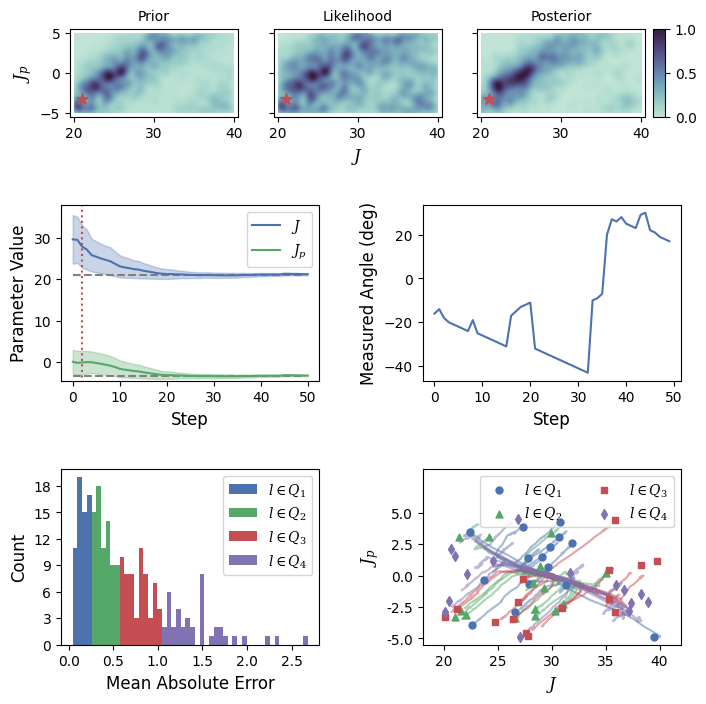

In [93]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3, 2, wspace=0.4, hspace=0.6, height_ratios=[.5, 1, 1])

# histogram
ax = fig.add_subplot(gs[-1, 0])

n, bins, patches = ax.hist(maes[:,-1], bins=50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
start_ids = []
for i in range(4):
    start = np.where(bin_centers > mae_sorted_quartiles[i].min())[0][0]
    start_ids.append(start)
    for patch in patches[start:]:
        patch.set_facecolor(f'C{i}')
        
# Add legend for each color
legend_labels = [fr'$l\in Q_{_j+1}$' for _j in range(4)]
legend_patches = [patches[start] for start in start_ids]
ax.legend(legend_patches, legend_labels)

ax.set_xlabel('Mean Absolute Error')
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0, np.ceil(n.max())+1, step=3))
ax.set_yticklabels(np.arange(0, np.ceil(n.max())+1, step=3).astype('int'))

# trajectory
ax = fig.add_subplot(gs[-1, 1])
for _j in range(4):
    np.random.seed(9)
    rdn_idx = np.random.choice(mae_sorted_quartiles_idx[_j], len(mae_sorted_quartiles_idx[_j]), replace=False)
    for _idx in rdn_idx:
        ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C{_j}', alpha=0.5, zorder=1)
        ax.scatter(true_values[_idx,0], true_values[_idx,1], 
                   color=f'C{_j}', marker=markers[_j], zorder=10, s=25,
                   label=fr'$l\in Q_{_j+1}$' if _idx==rdn_idx[0] else None)
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
ax.set_xlim(18, 42)
ax.set_xticks(np.linspace(20, 40, 5, dtype=int))
ax.set_xticklabels(np.linspace(20, 40, 5, dtype=int))
ax.set_ylim(-5.5, 8.5)
ax.set_yticks(np.linspace(-5, 5, 5))
ax.set_yticklabels(np.linspace(-5, 5, 5))
ax.legend(loc='upper right', ncol=2)

# mean value history
ax = fig.add_subplot(gs[1, 0])
ax.plot(np.arange(demo_pt['means'].shape[0]), demo_pt['means'])
# ax.scatter([idx_prior, idx_prior], [demo_pt['means'][idx_prior,0], demo_pt['means'][idx_prior,1]], marker='o', color='C2', zorder=10, s=25)
ax.vlines(idx_prior, -5, 40, color='C2', linestyle=':')
ax.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,0], 
                (demo_pt['means'] + std)[:,0], alpha=0.3, color='C0')
ax.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,1], 
                (demo_pt['means'] + std)[:,1], alpha=0.3, color='C1')
ax.hlines(demo_pt['true_params'], 0, 49, color='gray', linestyle='--')
# ax.plot([idx_prior, idx_prior+1], [demo_pt_mean[i] for i in [idx_prior,idx_prior+1]], 'o', color='C2')
ax.legend(['$J$', '$J_{p}$'])
ax.set_xlabel('Step')
ax.set_ylabel('Parameter Value')
ax.set_ylim([-4.5, 38])

# measured angle
ax = fig.add_subplot(gs[1, 1])
ax.plot(_measured_angles)
ax.set_xlabel('Step')
ax.set_ylabel('Measured Angle (deg)')

# probability density
# ax = fig.add_subplot(gs[2, :]
# )

sub_gs = gs[0, :].subgridspec(1, 4, wspace=0.125, width_ratios=[1, 1, 1, 0.05])

ax = fig.add_subplot(sub_gs[0, 0])
im0 = ax.imshow(kde_prior, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax.set_title('Prior')
# ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
ax.scatter(*demo_pt['true_params'], s=75, marker='*', color='C2')
ax.set_xlim(19.5, 40.5)
ax.set_ylim(-5.5, 5.5)

ax = fig.add_subplot(sub_gs[0, 1])
im1 = ax.imshow(kde_lkhd, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax.scatter(*demo_pt['true_params'], s=75, marker='*', color='C2')
ax.set_title('Likelihood')
ax.set_xlabel('$J$')
ax.set_xlim(19.5, 40.5)
ax.set_ylim(-5.5, 5.5)
ax.set_yticklabels([])

ax = fig.add_subplot(sub_gs[0, 2])
im2 = ax.imshow(kde_poste, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax.scatter(*demo_pt['true_params'], s=75, marker='*', color='C2')
ax.set_title('Posterior')
# ax.set_xlabel('$J$')
ax.set_xlim(19.5, 40.5)
ax.set_ylim(-5.5, 5.5)
ax.set_yticklabels([])

fig.tight_layout()

frac_pos = ax.get_position(False)
print(frac_pos)

# Add colorbar
cbar_ax = fig.add_axes([
    frac_pos.x1+0.01, frac_pos.y0, 
    0.015, frac_pos.y1-frac_pos.y0])

fig.colorbar(im2, cax=cbar_ax)

fig.savefig('figures/siml_benchmark_summary.pdf', bbox_inches='tight')

In [77]:
demo_pt['means'][2]

tensor([27.8874, -0.0851], dtype=torch.float64)